# Model Building
This notebooks contains the the model building for the first iteration - including model optimization via gridsearch

# Imports

In [1]:
# Necessary to import custom modules
import os
os.chdir("/home/jovyan/work")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import GridSearchCV

%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 10)

# Construct data

In [3]:
# read features and drop obsolete ones
df_raw = pd.read_csv("./data/features/second_iteration.csv")

In [4]:
df_raw.head()

,season,team_home,team_guest,avg_pts_home,avg_pts_guest,score_home,score_guest,home_win
0,2016/2017,Atlanta Hawks,Utah Jazz,865.50,873.25,95,120,0
1,2016/2017,Atlanta Hawks,Toronto Raptors,865.50,890.25,105,99,1
2,2016/2017,Atlanta Hawks,Houston Rockets,968.75,1229.75,112,97,1
3,2016/2017,Atlanta Hawks,Brooklyn Nets,602.50,834.00,92,107,0
4,2016/2017,Atlanta Hawks,Boston Celtics,818.00,1148.25,123,116,1


In [9]:
# construct training data
df_train = \
    df_raw[df_raw["season"].isin(["2016/2017"])]\
    .drop(["team_home", "team_guest", "score_home", "score_guest", "season"], axis=1)

X_train, y_train = df_train.drop(["home_win"], axis=1).values, df_train["home_win"].values

In [10]:
# construct final validation data
df_val = \
    df_raw[df_raw["season"] == "2017/2018"]\
    .drop(["team_home", "team_guest", "score_home", "score_guest", "season"]
          + [col for col in df_raw.columns if "2017/2018" in col] , axis=1)
X_val, y_val = df_val.drop(["home_win"], axis=1).values, df_val["home_win"].values

# Baseline

### Predict always win

In [12]:
log_loss(y_val, np.ones_like(y_val))

14.504364428156217

### Predict always loss

In [13]:
log_loss(y_val, np.zeros_like(y_val))

20.034747745413874

### Predict always draw

In [14]:
log_loss(y_val, np.ones_like(y_val)*.5)

0.69314718055994529

# Logistic Regression

In [18]:
# parameter grid
pg_lr = {
    "penalty": ["l1", "l2"],
    "C": [0.001, 0.01, 0.1, 1.0, 10],
}

# cross validated estimator
GS_LR = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=pg_lr,
    cv=5,
    n_jobs=-1,
    scoring="neg_log_loss"
)

# model fitting
GS_LR.fit(X_train, y_train)

# evaluate on validation set
log_loss(y_val, GS_LR.predict_proba(X_val))

0.64703171907337986

# Random Forest

In [16]:
# parameter grid
param_grid = {
    "n_estimators": [10, 15, 20],
    "min_samples_leaf": [1, 2, 3, 4, 5],
    "min_samples_split": [2, 3, 4, 5]
}

# cross validated estimator
GS_RF = GridSearchCV(
    estimator=RandomForestClassifier(),
    param_grid=param_grid,
    n_jobs=-1,
    cv=5,
    scoring="neg_log_loss"
)

# model fitting
GS_RF.fit(X_train, y_train)

# evaluate on validation set
log_loss(y_val, GS_RF.predict_proba(X_val))

0.69730383803716067

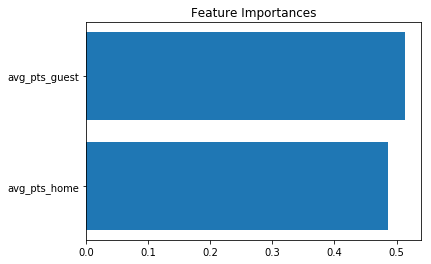

In [17]:
forest = GS_RF.best_estimator_
imps = forest.feature_importances_
idx = np.argsort(imps)
cols = df_train.drop(["home_win"], axis=1).columns[idx]

plt.barh(range(len(imps)), imps[idx])
plt.yticks(range(len(imps)), cols[idx])
plt.title("Feature Importances");